In [2]:
import math
import statistics
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
from pandas import datetime
from numpy import sqrt
from numpy import log
from matplotlib import pyplot as plt
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error
from random import seed
from random import random
from matplotlib.collections import LineCollection
from matplotlib import colors as mcolors
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from numpy import polyfit
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.gofplots import qqplot
from pandas.plotting import lag_plot
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import ARResults
from lightgbm import LGBMRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm_notebook
from itertools import product
from arch import arch_model
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.forecasting.theta import ThetaModel
import warnings
warnings.filterwarnings('ignore')
from statsforecast import StatsForecast
from statsforecast.models import (
    AutoARIMA,
    HoltWinters,
    CrostonClassic as Croston, 
    HistoricAverage,
    DynamicOptimizedTheta as DOT,
    SeasonalNaive
)
from datasetsforecast.losses import mse, mae, rmse
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

C:\Users\Ivan\AppData\Local\Temp\ipykernel_26944\455821674.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


This notebook's objective is not to properly anticipate the price of gold, but rather to introduce various "Statistical Models" and explore their potentials, as well as to perform some statistical analysis on the gold price as a non-stationary time series.

In [8]:
Gold = pd.read_csv(r'G_HistoricalData.csv', header=0, index_col=0, parse_dates=True,squeeze=True)
Gold = Gold.rename(columns={"Close/Last": "Close"})

Gold = Gold[Gold.Open !=0]
Gold = Gold[Gold.High !=0]
Gold = Gold[Gold.Low !=0]
Gold = Gold[Gold.Close !=0]
Gold

,Close,Volume,Open,High,Low
Date,,,,,
2023-05-23,1974.5,207433.0,1973.9,1980.0,1955.8
2023-05-22,1977.2,161997.0,1979.4,1981.1,1973.4
2023-05-19,1981.6,228720.0,1960.5,1987.4,1956.3
2023-05-18,1959.8,221594.0,1985.6,1988.8,1954.4
2023-05-17,1984.9,200251.0,1993.0,1997.0,1978.1
...,...,...,...,...,...
2013-05-30,1412.0,184922.0,1392.9,1417.7,1388.4
2013-05-29,1391.8,122484.0,1380.9,1395.4,1379.7
2013-05-28,1379.7,117343.0,1394.1,1401.9,1372.8



Statsforecast Library, Part One

Only the statsforecast library is utilized in this section. "StatsForecast provides a range of popular univariate time series forecasting models, such as automated ARIMA, ETS, CES, and Theta modeling, which are all highly performant numba-optimized models. A sizable number of benchmarking models are also included.

When looking for the best application of statistical models for time series, I came across this library. You'll notice that this library is fantastic and quite simple to use.

The majority of this section's explanation is taken from the statsforecast document linked below.

https://nixtla.github.io/statsforecast/examples/getting_started_complete.html
Reading the Data

StatsForecast always accepts a long-formatted data frame with three columns: unique_id, ds, and y:

The unique_id (string, int or category) represents an identifier for the series.

The ds (datestamp or int) column should be either an integer indexing time or a datestampe ideally like YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp.

The y (numeric) represents the measurement we wish to forecast. We can rename it to our arbitrary name. Here we don't change it.

An identification for the series is represented by the unique_id (string, int, or category).

Datestamps should preferably be formatted as YYYY-MM-DD for dates and YYYY-MM-DD HH:MM:SS for timestamps in the ds (datestamp or int) column.

The measurement we want to predict is represented by the letter y (a numeric). We can give it a new name of our own. Here, we leave it alone.

In [9]:
x = pd.Series(Gold['High'].values, index=pd.date_range("2000-08-30", freq="D", periods=Gold.shape[0]))

In [10]:
High = pd.DataFrame(columns = ['unique_id','ds','y'])
High['unique_id'] = ['High' for i in range(Gold.shape[0])]
High['ds'] = x.index
High['y'] = Gold['High'].values
High

,unique_id,ds,y
0,High,2000-08-30,1980.0
1,High,2000-08-31,1981.1
2,High,2000-09-01,1987.4
3,High,2000-09-02,1988.8
4,High,2000-09-03,1997.0
...,...,...,...
2536,High,2007-08-10,1417.7
2537,High,2007-08-11,1395.4
2538,High,2007-08-12,1401.9
2539,High,2007-08-13,1386.6


In [11]:
from statsforecast import StatsForecast
StatsForecast.plot(High)
StatsForecast.plot(High.tail(90))
StatsForecast.plot(High.tail(60))
StatsForecast.plot(High.tail(30))

Automatic Forecasting: For a set of time series, automatic forecasting systems look for the best parameters and choose the best model. For huge sets of univariate time series, these tools are helpful. Arima, ETS, Theta, and CES automatic versions are included.

Utilizes an exponentially decreasing weighted average of all previous data, or exponential smoothing. Appropriate for data without a distinct pattern or seasonality. SES, Holt's Winters, and SSO are some examples.

Traditional baseline models are called benchmark models. Examples include mean, nave, and random walk.

Models that are intermittent or sparse are appropriate for series with few non-zero observations. For instance, CROSTON, ADIDA, and IMAPA

Signals having many distinct seasonalities are best suited for multiple seasonalities. appropriate for low-frequency data such as electricity and logs. MSTL is an example.

Theta models are used to fit two theta lines to a deseasonalized time series. The two theta lines are obtained and combined using various methods to provide the final forecasts. Examples: DynamicTheta, Theta



Models Used Here

Here we will use:

- Using an information criterion, AutoARIMA automatically chooses the optimum ARIMA (AutoRegressive Integrated Moving Average) model. AutoARIMA is cited.

- For series that incorporate both trend and seasonality, Holt-Winters' method—also known as triple exponential smoothing—is an extension of exponential smoothing. citation: HoltWinters

- Memory-efficient seasonal naive predictions are known as seasonalNaive. Citation: SeasonalNaive

- Arthimetic mean for historical average. Historical Average.

- DynamicOptimizedTheta: Performance of the theta family of models has been demonstrated in a number of datasets, including M3. deseasonalized time series is modeled. DynamicOptimizedTheta is cited.

Import the models, then instantiate them. Sometimes it's challenging to set the season_length parameter.

There are typically several ways to handle the frequency if observations occur more frequently than once per week. For instance, data with daily observations may exhibit weekly (frequency = 7) or annual (frequency = 365.25) seasonality. Similar to this, data that are seen every minute may exhibit seasonality on an hourly (frequency=60), daily (frequency=24x60=1440), weekly (frequency=24x60x7=10080), and annual (frequency=24x60x365.25=525960) scales. You must choose which of these is more crucial if you want to use a ts object. - Robert J. Hyndman

In [12]:
models = [
    AutoARIMA(season_length=24),
    HoltWinters(),
    Croston(),
    SeasonalNaive(season_length=24),
    
    DOT(season_length=24)
]

We fit the models by instantiating a new StatsForecast object with the following parameters:

- models: a list of models. Select the models you want from models and import them.

- freq: a string indicating the frequency of the data. (See panda’s available frequencies.)

- n_jobs: n_jobs: int, number of jobs used in the parallel processing, use -1 for all cores.

- fallback_model: a model to be used if a model fails.

Any settings are passed into the constructor. Then you call its fit method and pass in the historical data frame.

In [13]:
# Instantiate StatsForecast class as sf
sf = StatsForecast(
    df=High.head(High.shape[0]-14), 
    models=models,
    freq='D', #freq='D' means daily frequency
    n_jobs=-1,
    fallback_model = SeasonalNaive(season_length=7)
)

In [14]:
forecasts_df = sf.forecast(h=14, level=[90])

forecasts_df

,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90,HoltWinters,HoltWinters-lo-90,HoltWinters-hi-90,CrostonClassic,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90,DynamicOptimizedTheta,DynamicOptimizedTheta-lo-90,DynamicOptimizedTheta-hi-90
unique_id,,,,,,,,,,,,,,
High,2007-08-01,1394.525024,1371.929565,1417.120605,1301.699951,1216.099976,1387.299927,1327.456299,1292.000000,1185.622437,1398.377563,1395.972168,1375.556396,1421.723145
High,2007-08-02,1394.525024,1361.790771,1427.259399,1351.199951,1265.599976,1436.799927,1327.456299,1283.500000,1177.122437,1389.877563,1397.493652,1366.599609,1429.757935
High,2007-08-03,1394.525024,1354.120728,1434.929321,1376.000000,1290.400024,1461.599976,1327.456299,1287.400024,1181.022461,1393.777588,1398.539429,1353.716553,1436.754517
High,2007-08-04,1394.525024,1347.690430,1441.359741,1385.400024,1299.800049,1471.000000,1327.456299,1297.199951,1190.822388,1403.577515,1396.481567,1351.198242,1435.451660
High,2007-08-05,1394.525024,1342.042114,1447.007935,1391.400024,1305.800049,1477.000000,1327.456299,1264.500000,1158.122437,1370.877563,1397.193970,1350.562256,1444.354492
High,2007-08-06,1394.525024,1336.945312,1452.104858,1391.800049,1306.200073,1477.400024,1327.456299,1258.699951,1152.322388,1365.077515,1399.190430,1340.687988,1452.306641
High,2007-08-07,1394.525024,1332.264282,1456.785889,1394.400024,1308.800049,1480.000000,1327.456299,1237.400024,1131.022461,1343.777588,1398.321289,1332.748901,1454.869019
High,2007-08-08,1394.525024,1327.911377,1461.138672,1301.699951,1216.099976,1387.299927,1327.456299,1257.099976,1150.722412,1363.477539,1399.424072,1334.386719,1461.641479
High,2007-08-09,1394.525024,1323.826050,1465.224121,1351.199951,1265.599976,1436.799927,1327.456299,1251.900024,1145.522461,1358.277588,1400.325562,1330.573608,1465.456299


In [15]:
sf.plot(High.tail(30),forecasts_df)

Analysis the Performance of the Model

We've used our prior data to make predictions in earlier steps. However, we would also need to know how the model would have performed in the past to evaluate its accuracy. Use cross-validation to evaluate the robustness and correctness of your models on your data.

In order to do cross validation on time series data, a sliding window across the historical data must be defined, and the period immediately after it must be predicted. This method of cross-validation keeps the data in the training set contiguous, as required by our models, and enables us to estimate the prediction power of our model over a larger range of temporal instances.

Although most implementations of cross-validation of time series models are quite sluggish, it is regarded as a best practice. Cross-validation is implemented as a distributed operation using the statsforecast library, which reduces the processing time. If you have large datasets, you can also use Ray, Dask, or Spark in a distributed cluster to perform cross validation.

In this instance, we want to assess how well each model performed over the previous 14 days (n_windows=14), forecasting every two days (step_size=2).

The following inputs are accepted by the cross_validation method from the StatsForecast class.

- df: training data frame

- h (int): represents h steps into the future that are being forecasted. In this case,14 days ahead.

- step_size (int): step size between each window. In other words: how often do you want to run the forecasting processes.

- n_windows(int): number of windows used for cross validation. In other words: what number of forecasting processes in the past do you want to evaluate.

In [16]:
crossvaldation_df = sf.cross_validation(
    df=High,
    h=14,
    step_size=2,
    n_windows=14
  )
crossvaldation_df

,ds,cutoff,y,AutoARIMA,HoltWinters,CrostonClassic,SeasonalNaive,DynamicOptimizedTheta
unique_id,,,,,,,,
High,2007-07-06,2007-07-05,1289.199951,1296.074341,1338.500000,1336.205078,1378.900024,1297.650513
High,2007-07-07,2007-07-05,1301.099976,1296.074341,1340.900024,1336.205078,1378.000000,1295.838623
High,2007-07-08,2007-07-05,1292.000000,1296.074341,1333.699951,1336.205078,1384.099976,1297.411865
High,2007-07-09,2007-07-05,1283.500000,1296.074341,1347.400024,1336.205078,1379.199951,1298.882690
High,2007-07-10,2007-07-05,1287.400024,1296.074341,1335.199951,1336.205078,1369.599976,1299.787354
...,...,...,...,...,...,...,...,...
High,2007-08-10,2007-07-31,1417.699951,1394.525024,1376.000000,1327.456299,1259.300049,1399.797607
High,2007-08-11,2007-07-31,1395.400024,1394.525024,1385.400024,1327.456299,1267.000000,1398.976196
High,2007-08-12,2007-07-31,1401.900024,1394.525024,1391.400024,1327.456299,1261.699951,1397.344604


In [17]:
def evaluate_cross_validation(df, metric):
    models = df.drop(columns=['ds', 'cutoff', 'y']).columns.tolist()
    evals = []
    for model in models:
        eval_ = df.groupby(['unique_id', 'cutoff']).apply(lambda x: metric(x['y'].values, x[model].values)).to_frame() # Calculate loss for every unique_id, model and cutoff.
        eval_.columns = [model]
        evals.append(eval_)
    evals = pd.concat(evals, axis=1)
    evals = evals.groupby(['unique_id']).mean(numeric_only=True) # Averages the error metrics for all cutoffs for every combination of model and unique_id
    evals['best_model'] = evals.idxmin(axis=1)
    return evals

In [18]:
evaluation_df = evaluate_cross_validation(crossvaldation_df, rmse)

evaluation_df

,AutoARIMA,HoltWinters,CrostonClassic,SeasonalNaive,DynamicOptimizedTheta,best_model
unique_id,,,,,,
High,58.420128,81.532219,80.436104,90.031433,59.617744,AutoARIMA


In [19]:
seasonal_ids = evaluation_df.query('best_model == "AutoARIMA"').index

sf.plot(High.tail(30),forecasts_df, unique_ids=seasonal_ids, models=["AutoARIMA","DynamicOptimizedTheta"])

In [20]:
def get_best_model_forecast(forecasts_df, evaluation_df):
    df = forecasts_df.set_index('ds', append=True).stack().to_frame().reset_index(level=2) # Wide to long 
    df.columns = ['model', 'best_model_forecast'] 
    df = df.join(evaluation_df[['best_model']])
    df = df.query('model.str.replace("-lo-90|-hi-90", "", regex=True) == best_model').copy()
    df.loc[:, 'model'] = [model.replace(bm, 'best_model') for model, bm in zip(df['model'], df['best_model'])]
    df = df.drop(columns='best_model').set_index('model', append=True).unstack()
    df.columns = df.columns.droplevel()
    df = df.reset_index(level=1)
    return df
    
prod_forecasts_df = get_best_model_forecast(forecasts_df, evaluation_df)

prod_forecasts_df.head()

model,ds,best_model,best_model-hi-90,best_model-lo-90
unique_id,,,,
High,2007-08-01,1394.525024,1417.120605,1371.929565
High,2007-08-02,1394.525024,1427.259399,1361.790771
High,2007-08-03,1394.525024,1434.929321,1354.120728
High,2007-08-04,1394.525024,1441.359741,1347.690430
High,2007-08-05,1394.525024,1447.007935,1342.042114


In [21]:
sf.plot(High.tail(30), prod_forecasts_df, level=[90])

End of Part 1

Keep in mind that getting the best accuracy and score was not the goal in this case. I simply wanted to introduce the "statsforecast" library's uses for statistical models. I'm confident that we can improve the accuracy of the results by adjusting the hyperparameters of these models.

Statistical Analysis, Part Two

In this section, we attempt to analyze our time series, determine whether it is steady or not, and apply a few models using the "statsmodels" library.

In [22]:
Gold

,Close,Volume,Open,High,Low
Date,,,,,
2023-05-23,1974.5,207433.0,1973.9,1980.0,1955.8
2023-05-22,1977.2,161997.0,1979.4,1981.1,1973.4
2023-05-19,1981.6,228720.0,1960.5,1987.4,1956.3
2023-05-18,1959.8,221594.0,1985.6,1988.8,1954.4
2023-05-17,1984.9,200251.0,1993.0,1997.0,1978.1
...,...,...,...,...,...
2013-05-30,1412.0,184922.0,1392.9,1417.7,1388.4
2013-05-29,1391.8,122484.0,1380.9,1395.4,1379.7
2013-05-28,1379.7,117343.0,1394.1,1401.9,1372.8


In [23]:
def accuracy(actual,predict):

    x = [i for i in range(len(actual))]


    #x = pd.DataFrame(Bit.index[-60:]).values

    mae = mean_absolute_error(actual, predict)
    rmse = sqrt(mean_squared_error(actual, predict))
    mse = mean_squared_error(actual, predict)


    """The best case for both diff in the following is small positive numbers
    which means the prediction is accurate and the trading strategy is possible.""" 


    compare = pd.DataFrame(columns=['Actual','Predict'])
    compare['Actual'] = actual
    compare['Predict'] = predict

    print('MAE: %f' % mae)
    print('RMSE: %f' % rmse)
    print('MSE: %f' % mse)

    # plot lines
    plt.plot(x, predict,'--bo', label = "predict",linestyle = 'dashed',color='C6')
    plt.plot(x, actual,marker='o', label = "Actual")
    plt.xticks(rotation = 90)
    plt.legend()
    plt.show()

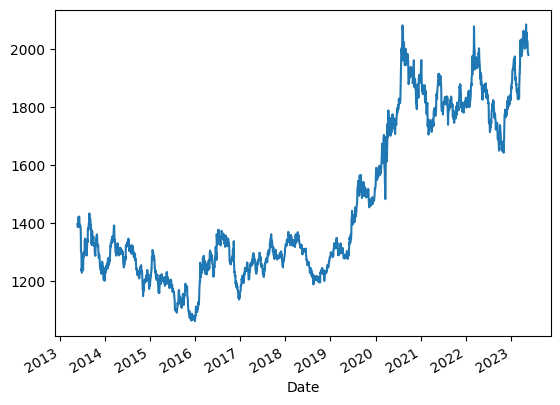

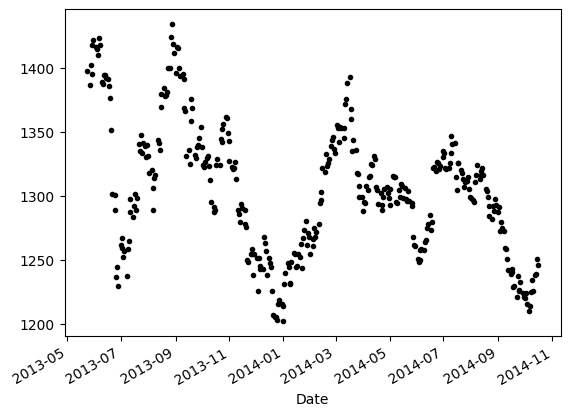

In [24]:
target_series = Gold['High']
target_series.plot()
plt.show()
target_series[-365:].plot(style='k.')
plt.show()

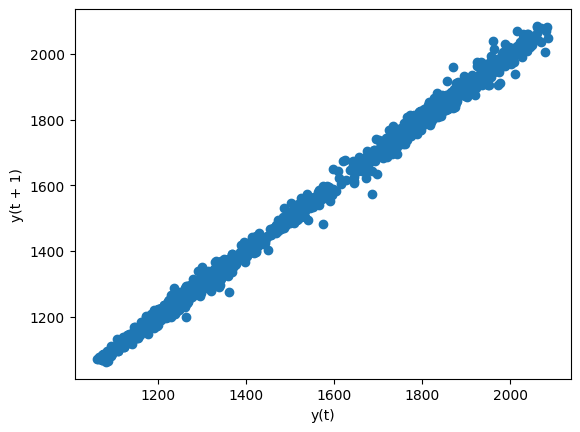

In [25]:
lag_plot(target_series)
plt.show()

We can discern a completely linear relationship between each following day and the figure above. However, this linearity partially vanishes when we focus in and take just 60 days into account.

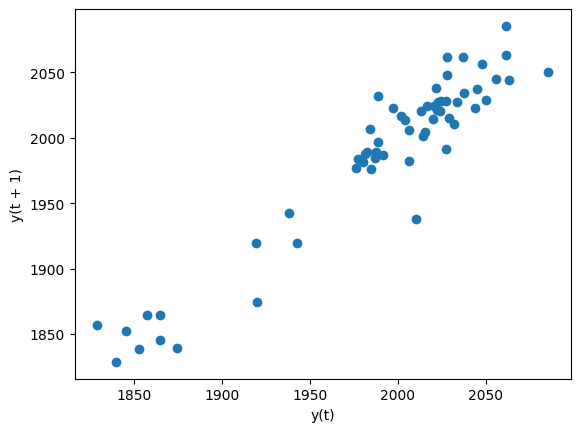

In [26]:
lag_plot(target_series[:60])
plt.show()

Plots of Autocorrelation
- The nature and degree of the relationship between observations and their lags can be quantified.
- A correlation measure that compares two sets of data, like observations and their lag=1 values


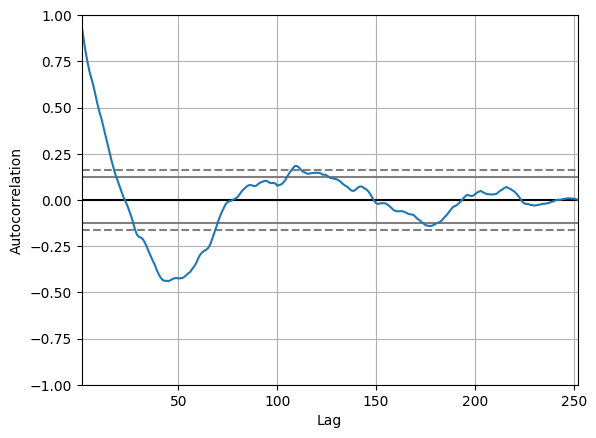

In [27]:
autocorrelation_plot(target_series['2021'])
plt.show()

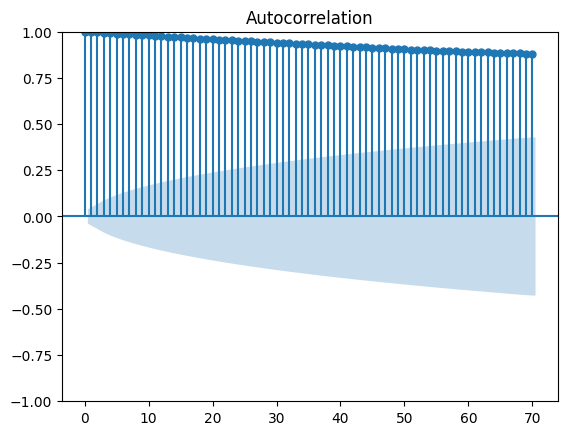

In [28]:
plot_acf(target_series, lags=70)
plt.show()

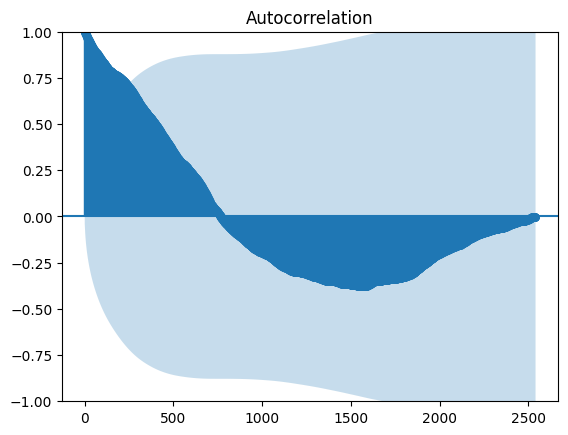

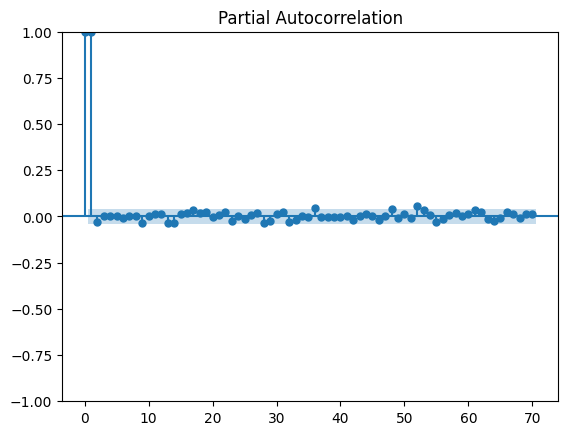

In [29]:
plot_acf(target_series, lags=target_series.shape[0]-1)
plt.show()

plot_pacf(target_series, lags=70)
plt.show()

In [30]:
def check_stationary(series):

    def reverse_dictionary(dictionary):

        reverse = {}
        counter = 0
        for val in list(dictionary.values()):
            reverse[val] = list(dictionary.keys())[counter]
            counter = counter + 1
        return reverse

    check_adf = 0
    result_adf = adfuller(series)
    print('=====ADF Result=====')
    print('ADF Statistic: %f' % result_adf[0])
    print('p-value: %f' % result_adf[1])
    print('Critical Values:')
    for key, value in result_adf[4].items():
        print('\t%s: %.3f' % (key, value))
    
    if result_adf[1] > 0.05:
        print(result_adf[1],'>',0.05)
        check_adf = check_adf + 1
    
    max_critical_val_adf = max(list(result_adf[4].values()))
    reverse_adf = reverse_dictionary(result_adf[4])
    if result_adf[0] > max_critical_val_adf:
        print('ADF Statistic: %f' % result_adf[0],'>','Max Critical Values:' ,reverse_adf[max_critical_val_adf],':',max_critical_val_adf)
        check_adf = check_adf + 1
    
    if check_adf > 0:
        print('By ADF Test, the time series is non_Stationary.')
        print('The Check score:',check_adf)
    else:
        print('By ADF Test, the time series is Stationary.')

    print('=====KPSS Result=====')
    check_kpss = 0
    result_kpss_ct=kpss(series,regression="ct")
    print('KPSS Statistic: %f' %result_kpss_ct[0])
    print('p-value: %f' %result_kpss_ct[1])
    print('Critical values:')
    for key, value in result_kpss_ct[3].items():
        print('\t%s: %.3f' %(key, value))

    if result_kpss_ct[1] < 0.05:
        print(result_kpss_ct[0],'<',0.05)
        check_kpss = check_kpss + 1
    
    max_critical_val_kpss = max(list(result_kpss_ct[3].values()))
    reverse_kpss = reverse_dictionary(result_kpss_ct[3])
    if result_kpss_ct[0] > max_critical_val_kpss:
        print('ADF Statistic: %f' % result_kpss_ct[0],'>','Max Critical Values:' ,reverse_kpss[max_critical_val_kpss],':',max_critical_val_kpss)
        check_kpss = check_kpss + 1
    
    if check_kpss > 0:
        print('By KPSS Test, the time series is non_Stationary.')
        print('The Check score:',check_kpss)
    else:
        print('By KPSS Test, the time series is Stationary.')
        
    print('========Final Result========')
    print('Overall Check Score:',check_kpss+check_adf)

In [31]:
check_stationary(target_series)

=====ADF Result=====
ADF Statistic: -1.977838
p-value: 0.296374
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
0.2963739140578471 > 0.05
ADF Statistic: -1.977838 > Max Critical Values: 10% : -2.5673763435766364
By ADF Test, the time series is non_Stationary.
The Check score: 2
=====KPSS Result=====
KPSS Statistic: 1.236888
p-value: 0.010000
Critical values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
1.2368877569278887 < 0.05
ADF Statistic: 1.236888 > Max Critical Values: 1% : 0.216
By KPSS Test, the time series is non_Stationary.
The Check score: 2
========Final Result========
Overall Check Score: 4


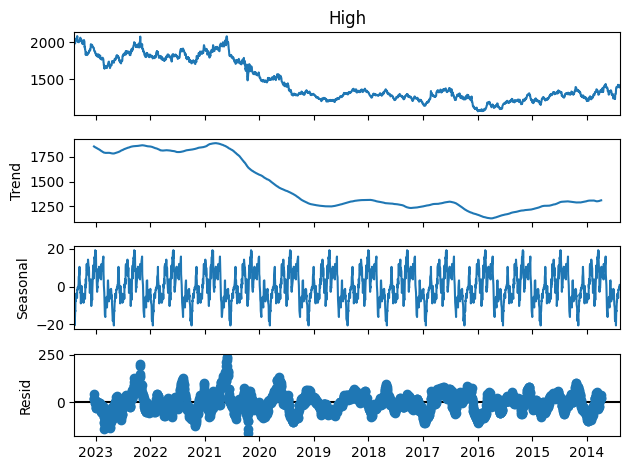

In [32]:
result = seasonal_decompose(target_series, model='additive',period =180)
result.plot()
plt.show()

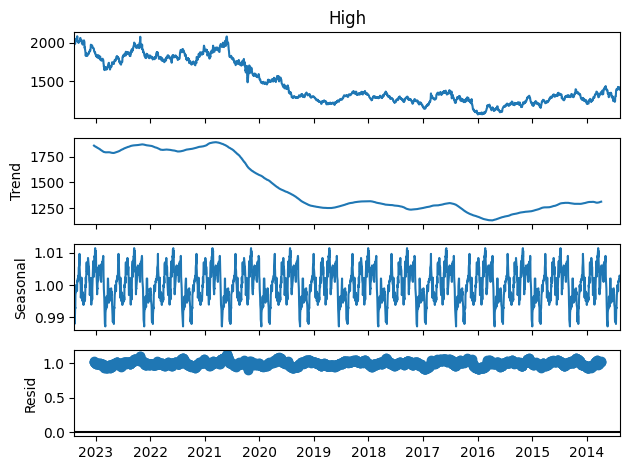

In [33]:
result = seasonal_decompose(target_series, model='multiplicative',period =180)
result.plot()
plt.show()

reciprocal transformation Lambda: -1.000000


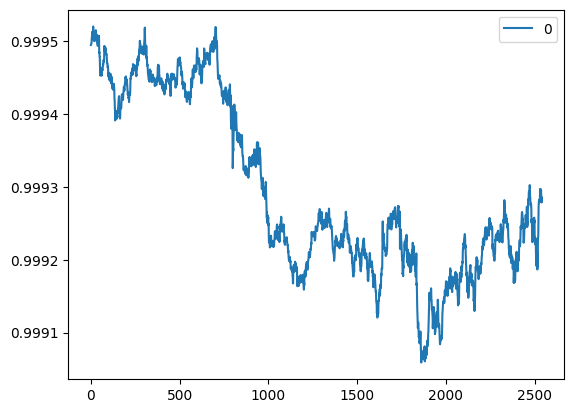

=====ADF Result=====
ADF Statistic: -1.841241
p-value: 0.360187
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
0.3601874480157713 > 0.05
ADF Statistic: -1.841241 > Max Critical Values: 10% : -2.567380433702844
By ADF Test, the time series is non_Stationary.
The Check score: 2
=====KPSS Result=====
KPSS Statistic: 1.131939
p-value: 0.010000
Critical values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
1.1319394768295497 < 0.05
ADF Statistic: 1.131939 > Max Critical Values: 1% : 0.216
By KPSS Test, the time series is non_Stationary.
The Check score: 2
========Final Result========
Overall Check Score: 4
reciprocal sqrt transformation Lambda: -0.500000


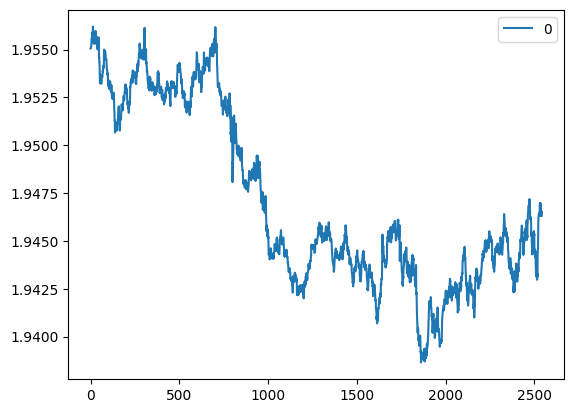

=====ADF Result=====
ADF Statistic: -1.840116
p-value: 0.360735
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
0.36073497362557727 > 0.05
ADF Statistic: -1.840116 > Max Critical Values: 10% : -2.5673761046872094
By ADF Test, the time series is non_Stationary.
The Check score: 2
=====KPSS Result=====
KPSS Statistic: 1.169294
p-value: 0.010000
Critical values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
1.1692939917387295 < 0.05
ADF Statistic: 1.169294 > Max Critical Values: 1% : 0.216
By KPSS Test, the time series is non_Stationary.
The Check score: 2
========Final Result========
Overall Check Score: 4
log transformation Lambda: 0.000000


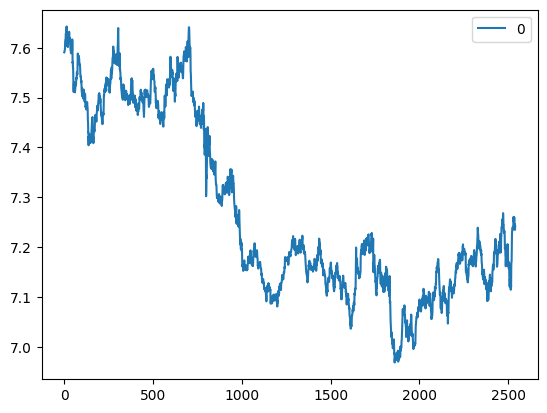

=====ADF Result=====
ADF Statistic: -1.866512
p-value: 0.347975
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
0.3479751677265407 > 0.05
ADF Statistic: -1.866512 > Max Critical Values: 10% : -2.5673761046872094
By ADF Test, the time series is non_Stationary.
The Check score: 2
=====KPSS Result=====
KPSS Statistic: 1.199655
p-value: 0.010000
Critical values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
1.1996553014842082 < 0.05
ADF Statistic: 1.199655 > Max Critical Values: 1% : 0.216
By KPSS Test, the time series is non_Stationary.
The Check score: 2
========Final Result========
Overall Check Score: 4
sqrt transformation Lambda: 0.500000


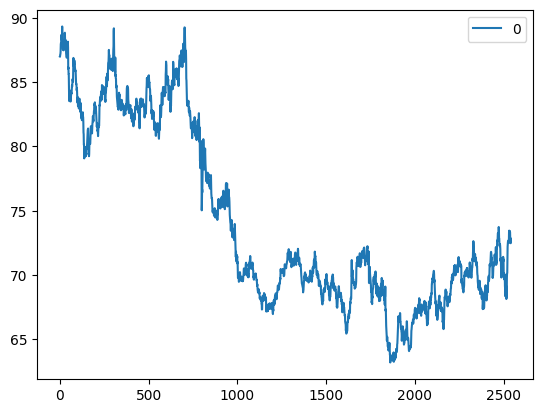

=====ADF Result=====
ADF Statistic: -1.928890
p-value: 0.318595
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
0.3185948249336372 > 0.05
ADF Statistic: -1.928890 > Max Critical Values: 10% : -2.5673763435766364
By ADF Test, the time series is non_Stationary.
The Check score: 2
=====KPSS Result=====
KPSS Statistic: 1.222305
p-value: 0.010000
Critical values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
1.2223048217310595 < 0.05
ADF Statistic: 1.222305 > Max Critical Values: 1% : 0.216
By KPSS Test, the time series is non_Stationary.
The Check score: 2
========Final Result========
Overall Check Score: 4
no transform transformation Lambda: 1.000000


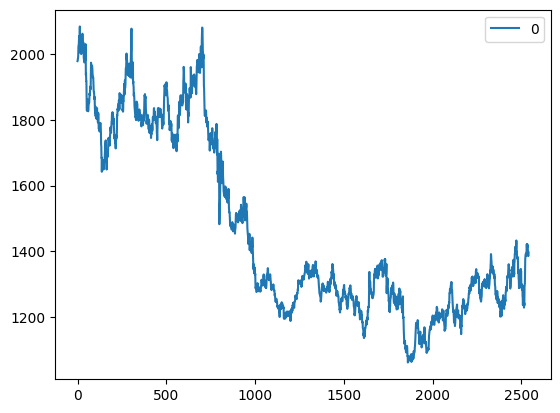

=====ADF Result=====
ADF Statistic: -1.977838
p-value: 0.296374
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
0.29637391405784763 > 0.05
ADF Statistic: -1.977838 > Max Critical Values: 10% : -2.5673763435766364
By ADF Test, the time series is non_Stationary.
The Check score: 2
=====KPSS Result=====
KPSS Statistic: 1.236888
p-value: 0.010000
Critical values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
1.2368877569278909 < 0.05
ADF Statistic: 1.236888 > Max Critical Values: 1% : 0.216
By KPSS Test, the time series is non_Stationary.
The Check score: 2
========Final Result========
Overall Check Score: 4


In [34]:


lambda_transform = {'reciprocal':-1,'reciprocal sqrt':-0.5,'log':0,'sqrt':0.5,'no transform':1}

for trans in list(lambda_transform.keys()):
    Lambda = lambda_transform[trans]
    print(trans,'transformation','Lambda: %f' % Lambda)
    High_Transformed = boxcox(target_series,Lambda)
    High_Transformed = pd.DataFrame(High_Transformed)
    High_Transformed.plot()
    plt.show()
    check_stationary(High_Transformed.values)
    print('==================================================')
    



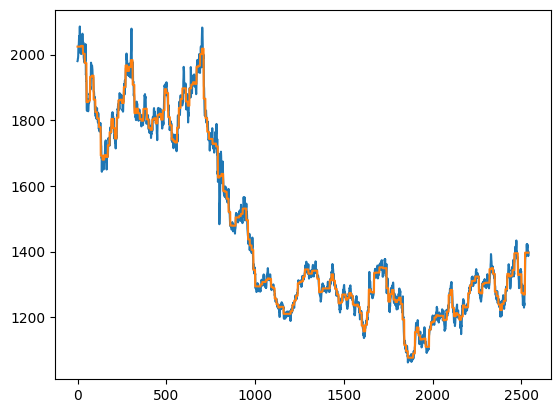

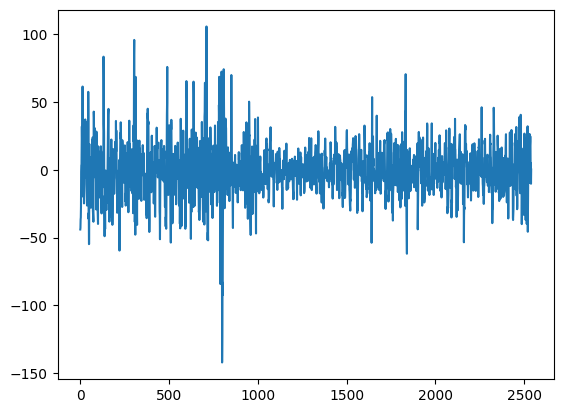

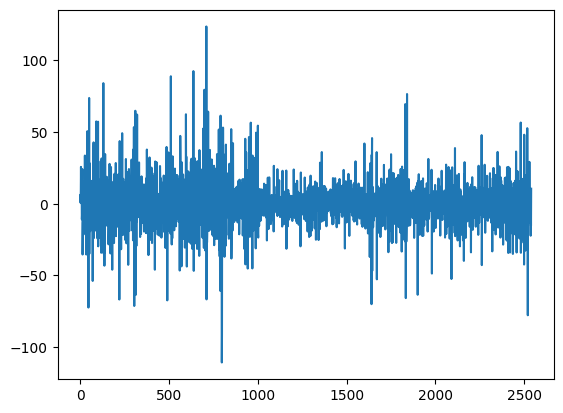

=====ADF Result=====
ADF Statistic: -14.591431
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
By ADF Test, the time series is Stationary.
=====KPSS Result=====
KPSS Statistic: 0.002203
p-value: 0.100000
Critical values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
By KPSS Test, the time series is Stationary.
========Final Result========
Overall Check Score: 0


In [35]:
X = [i for i in range(0, len(target_series))]
X = np.reshape(X, (len(X), 1))
y = target_series.values
model = LGBMRegressor()
model.fit(X, y)
# calculate trend
trend = model.predict(X)
# plot trend
plt.plot(y)
plt.plot(trend)
plt.show()
# detrend
detrended = [y[i]-trend[i] for i in range(0, len(target_series))]
# plot detrended
plt.plot(detrended)
plt.show()

double_detrended = [detrended[i+1]-detrended[i] for i in range(0, len(target_series)-1)]
plt.plot(double_detrended)
plt.show()
check_stationary(detrended)

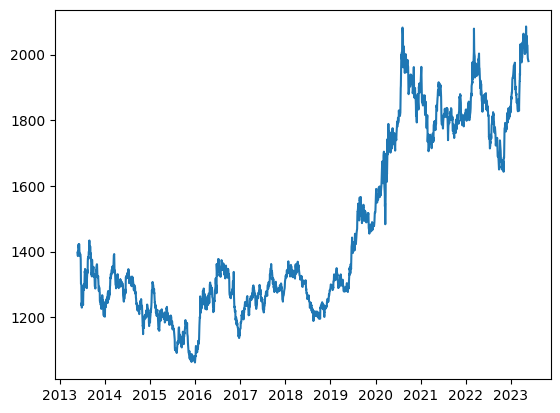

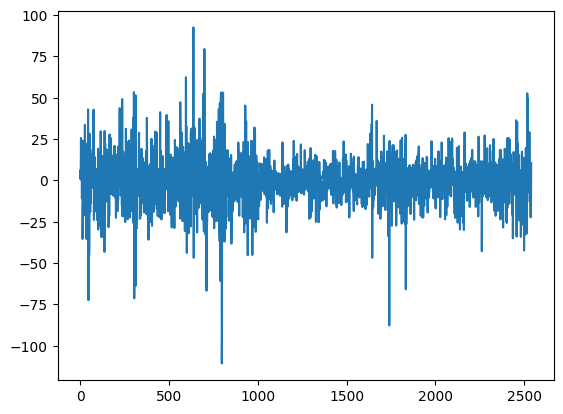

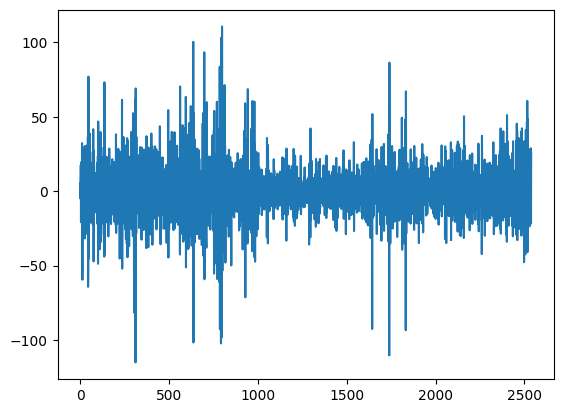

=====ADF Result=====
ADF Statistic: -48.092856
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
By ADF Test, the time series is Stationary.
=====KPSS Result=====
KPSS Statistic: 0.036461
p-value: 0.100000
Critical values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
By KPSS Test, the time series is Stationary.
========Final Result========
Overall Check Score: 0


In [36]:
def diff(X):
    diff = list()
    for i in range(1, len(X)):
        value = X[i] - X[i - 1]
        diff.append(value)
    return diff

X = target_series
plt.plot(X)
plt.show()

plt.plot(diff(X))
plt.show()

plt.plot(diff(diff(X)))
plt.show()
check_stationary(diff(X))

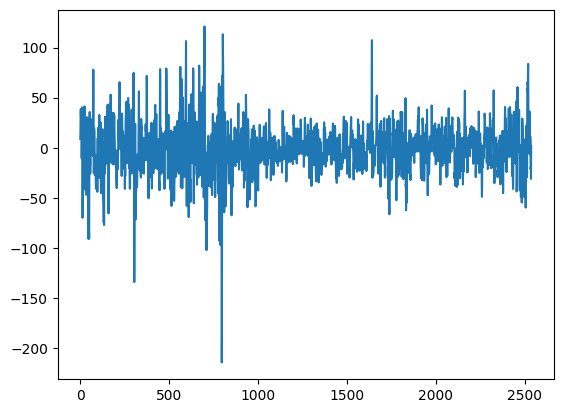

=====ADF Result=====
ADF Statistic: -9.556447
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
By ADF Test, the time series is Stationary.
=====KPSS Result=====
KPSS Statistic: 0.039382
p-value: 0.100000
Critical values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
By KPSS Test, the time series is Stationary.
========Final Result========
Overall Check Score: 0


In [37]:
X = target_series
diff = list()
season = 3  #try different value
for i in range(season, len(X)):
    value = X[i] - X[i - season]
    diff.append(value)
plt.plot(diff)
plt.show()
check_stationary(diff)

Coefficients: [ 6.08250164e-49 -7.06455400e-45  1.84019430e-41  1.18607484e-37
 -9.47132054e-34  2.25902576e-30  1.45517482e-27 -2.33181270e-23
  7.02139972e-20 -1.20682493e-16  1.35176774e-13 -1.01724303e-10
  5.09984478e-08 -1.64045513e-05  3.13791072e-03 -3.05675685e-01
  9.78289784e+00  1.94662412e+03]


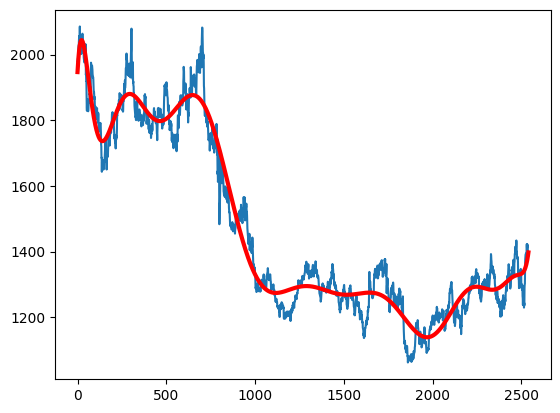

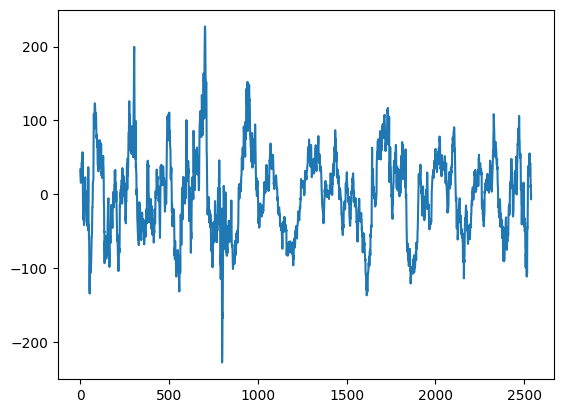

=====ADF Result=====
ADF Statistic: -6.677598
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
By ADF Test, the time series is Stationary.
=====KPSS Result=====
KPSS Statistic: 0.021491
p-value: 0.100000
Critical values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
By KPSS Test, the time series is Stationary.
========Final Result========
Overall Check Score: 0


In [38]:
series = target_series
X = [i%5500 for i in range(0, len(series))]
y = series.values
degree = 17
coef = polyfit(X, y, degree)
print('Coefficients: %s' % coef)
# create curve
curve = list()
for i in range(len(X)):
    value = coef[-1]
    for d in range(degree):
        value += X[i]**(degree-d) * coef[d]
    curve.append(value)
# plot curve over original data
plt.plot(series.values)
plt.plot(curve, color='red', linewidth=3)
plt.show()

# create seasonally adjusted
values = series.values
diff = list()
for i in range(len(values)):
    value = values[i] - curve[i]
    diff.append(value)
plt.plot(diff)
plt.show()
check_stationary(diff)

In [39]:
def diff(X):
    diff = list()
    for i in range(1, len(X)):
        value = X[i] - X[i - 1]
        diff.append(value)
    return diff
series_stationary = diff(target_series)
series_stationary[:7]



[1.099999999999909,
 6.300000000000182,
 1.3999999999998636,
 8.200000000000045,
 25.700000000000045,
 4.7999999999999545,
 0.2999999999999545]

MAE: 12.641667
RMSE: 17.241911
MSE: 297.283500


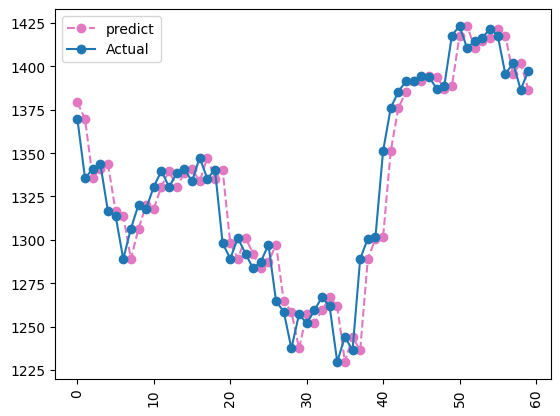

In [40]:
y_test = Gold['High'][-60:].values
baseline = Gold['High'].shift(1)[-60:].values
accuracy(y_test,baseline)

In [41]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
# prepare training dataset
    size = len(series_stationary)-60
    train, test = X[0:size], X[size:]
    history = [x for x in train]
    predictions = list()
    # walk-forward validation
    for t in range(len(test)):
        model = sm.tsa.arima.ARIMA(history, order=arima_order)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        #print('predicted=%f, expected=%f' % (yhat, obs))
    # evaluate forecasts
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# evaluate parameters
p_values = [1, 2, 3]
d_values = range(0, 2)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
#evaluate_models(series_stationary, p_values, d_values, q_values)

MAE: 12.593925
RMSE: 17.229602
MSE: 296.859201


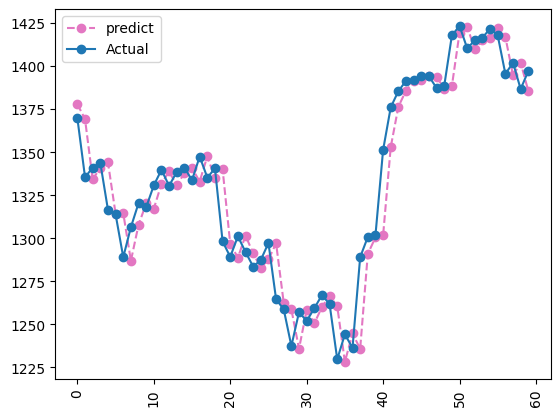

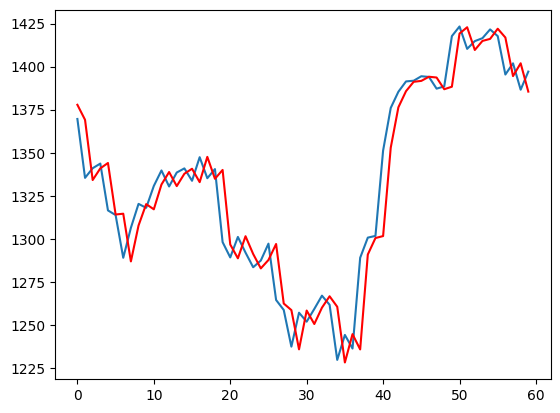

In [42]:
X = series_stationary
X_org = target_series.values
size = len(series_stationary)-60
train, test = X[0:size], X[size:]
train_org, test_org = X_org[0:size], X_org[size:]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = sm.tsa.arima.ARIMA(history, order=(4,1,3))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0] #+ test_org[t]
    predictions.append(yhat)
    obs = test[t] #+ test_org[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))

exact_prediction = []
for i in range(60):
    final = test_org[i] + predictions[i]
    exact_prediction.append(final)
# evaluate forecasts
accuracy(test_org[1:],exact_prediction)
# plot forecasts against actual outcomes
plt.plot(test_org[1:])
plt.plot(exact_prediction, color='red')
plt.show()

In [43]:
# because of the long time of runing this model, I write it as a funtion (bad function)
def sarima():
    X = series_stationary
    X_org = target_series.values
    size = len(series_stationary)-60
    train, test = X[:size], X[size:]
    train_org, test_org = X_org[1:size], X_org[size:]
    history = [x for x in train]
    exog = [diff(Gold['Close'].shift(1))[1:]]
    train_exog, test_exog = exog[:size], exog[size:]
    history_exog = [x for x in train_exog]
    predictions = list()
    Order=(2,1,2)
    Seasonal_order = (1,1,1,14)
    # walk-forward validation
    for t in range(len(test)):
        model = SARIMAX(history, order=Order,seasonal_order=Seasonal_order) #,exog = history_exog
        model_fit = model.fit()
        output = model_fit.forecast() #exog =test_exog
        yhat = output[0] #+ test_org[t]
        predictions.append(yhat)
        obs = test[t] #+ test_org[t]
        history.append(obs)
        #history_exog.append(test_exog[t])

    exact_prediction = []
    for i in range(60):
        final = test_org[i] + predictions[i]
        exact_prediction.append(final)
    # evaluate forecasts
    accuracy(test_org[1:],exact_prediction)
    # plot forecasts against actual outcomes
    plt.plot(test_org[1:])
    plt.plot(exact_prediction, color='red')
    plt.show()

Iteration:      1,   Func. Count:     18,   Neg. LLF: 10340.4889607445
Iteration:      2,   Func. Count:     36,   Neg. LLF: 10226.997516958629
Iteration:      3,   Func. Count:     55,   Neg. LLF: 10245.61745711316
Iteration:      4,   Func. Count:     73,   Neg. LLF: 10101.011249672445
Iteration:      5,   Func. Count:     91,   Neg. LLF: 10223.27344222298
Iteration:      6,   Func. Count:    110,   Neg. LLF: 10408.192234482809
Iteration:      7,   Func. Count:    128,   Neg. LLF: 10027.6228982902
Iteration:      8,   Func. Count:    146,   Neg. LLF: 10188.563890840003
Iteration:      9,   Func. Count:    165,   Neg. LLF: 10164.215415958872
Iteration:     10,   Func. Count:    183,   Neg. LLF: 10263.291895975088
Iteration:     11,   Func. Count:    201,   Neg. LLF: 10065.068467439876
Iteration:     12,   Func. Count:    220,   Neg. LLF: 9774.36437272182
Iteration:     13,   Func. Count:    238,   Neg. LLF: 9866.659021776893
Iteration:     14,   Func. Count:    256,   Neg. LLF: 9780.8

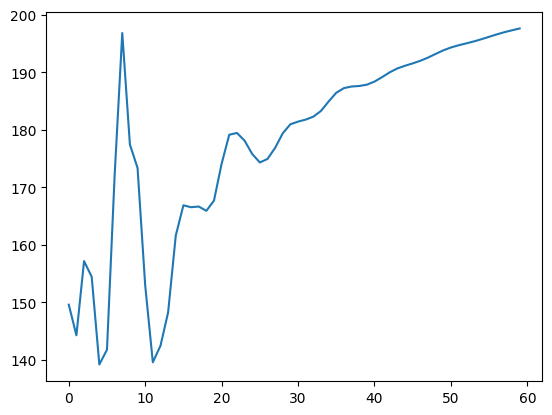

In [44]:
train,test = series_stationary[:-60],series_stationary[-60:]
# define model
model = arch_model(train, mean='Zero', vol='ARCH', p=15)
# fit model
model_fit = model.fit()
# forecast the test set
yhat = model_fit.forecast(horizon=60)
# plot the actual variance
Var_test = np.var(test)
#plt.plot(Var_test)
# plot forecast variance
plt.plot(yhat.variance.values[-1, :])
plt.show()

Iteration:      5,   Func. Count:    147,   Neg. LLF: 10216.939902673956
Iteration:     10,   Func. Count:    293,   Neg. LLF: 9870.416265308384
Iteration:     15,   Func. Count:    440,   Neg. LLF: 10035.5493084765
Iteration:     20,   Func. Count:    586,   Neg. LLF: 9713.525982356961
Iteration:     25,   Func. Count:    730,   Neg. LLF: 9714.485342568252
Iteration:     30,   Func. Count:    874,   Neg. LLF: 9711.156680474383
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9711.156649993132
            Iterations: 34
            Function evaluations: 985
            Gradient evaluations: 34
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -9711.16
Distribution:                  Normal   AI

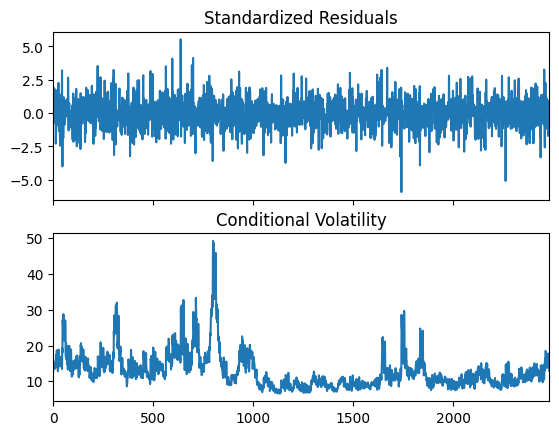

In [45]:
model = arch_model(series_stationary[:-60], p = 15,vol='GARCH', q = 10)
model_fit = model.fit(update_freq=5)
print(model_fit.summary())
model_fit.plot(); print()

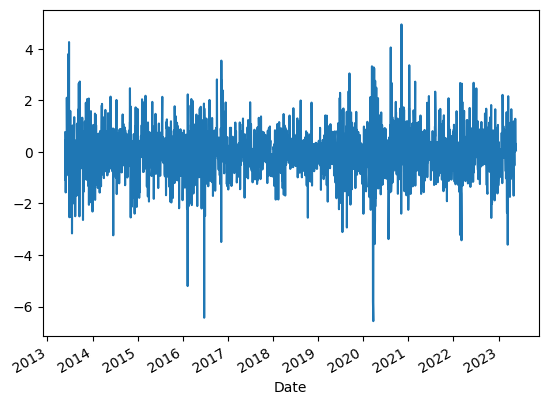

In [46]:
crd_inflation = 100 * Gold['High'].pct_change().dropna()
fig = crd_inflation.plot()

In [47]:
am = arch_model(crd_inflation)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     40,   Neg. LLF: 3394.265658473865
Iteration:     10,   Func. Count:     66,   Neg. LLF: 3193.4407882490837
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3193.440785949987
            Iterations: 12
            Function evaluations: 75
            Gradient evaluations: 12
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   High   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3193.44
Distribution:                  Normal   AIC:                           6394.88
Method:            Maximum Likelihood   BIC:                           6418.24
                                        No. Observations:                 2540
Date:                Wed, May 24 2023   Df Residuals:                     2539
Time:         

In [48]:
am = arch_model(crd_inflation,p=1,o=1,q=1,power=1.0)
res = am.fit(update_freq=5)
print(res.summary)

Iteration:      5,   Func. Count:     44,   Neg. LLF: 3247.6622502285077
Iteration:     10,   Func. Count:     81,   Neg. LLF: 3189.271335530755
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3189.2467910012965
            Iterations: 14
            Function evaluations: 106
            Gradient evaluations: 14
<bound method ARCHModelResult.summary of                   Constant Mean - TARCH/ZARCH Model Results                   
Dep. Variable:                   High   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                TARCH/ZARCH   Log-Likelihood:               -3189.25
Distribution:                  Normal   AIC:                           6388.49
Method:            Maximum Likelihood   BIC:                           6417.69
                                        No. Observations:                 2540
Date:                Wed, May 24 2023   Df Residua

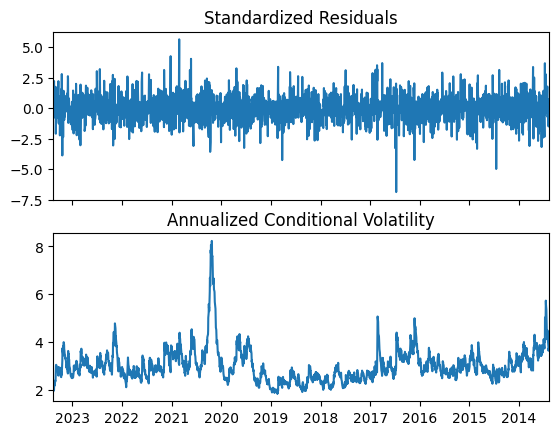

In [49]:
fig = res.plot(annualize = 'M')

In [50]:
am = arch_model(crd_inflation,p=1,o=0,q=1,power=1.0,dist='StudentsT')
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     42,   Neg. LLF: 3093.66544099912
Iteration:     10,   Func. Count:     77,   Neg. LLF: 3091.009644834873
Iteration:     15,   Func. Count:    106,   Neg. LLF: 3090.979849854982
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3090.9798498549953
            Iterations: 15
            Function evaluations: 106
            Gradient evaluations: 15
                       Constant Mean - AVGARCH Model Results                        
Dep. Variable:                         High   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                          AVGARCH   Log-Likelihood:               -3090.98
Distribution:      Standardized Student's t   AIC:                           6191.96
Method:                  Maximum Likelihood   BIC:                           6221.16
                                              No. Observations: 

In [51]:
data = Gold['High']
from collections import OrderedDict
crude_ret = 100 * data.dropna().pct_change().dropna()
res_normal = arch_model(crude_ret).fit(disp='off')
res_t = arch_model(crude_ret, dist='t').fit(disp='off')
res_skewt = arch_model(crude_ret, dist='skewt').fit(disp='off')
lls = pd.Series(
    OrderedDict((('normal', res_normal.loglikelihood),
                 ('t', res_t.loglikelihood), ('skewt',
                                              res_skewt.loglikelihood))))
print(lls)
params = pd.DataFrame(
    OrderedDict((('normal', res_normal.params), ('t', res_t.params),
                 ('skewt', res_skewt.params))))
params

normal   -3193.440786
t        -3095.247399
skewt    -3094.578226
dtype: float64


,normal,t,skewt
alpha[1],0.070382,0.064182,0.065387
beta[1],0.888888,0.890538,0.887206
eta,NaN,NaN,4.592360
lambda,NaN,NaN,-0.029886
mu,-0.006524,0.000704,-0.007795
nu,NaN,4.611506,NaN
omega,0.032830,0.038308,0.040122


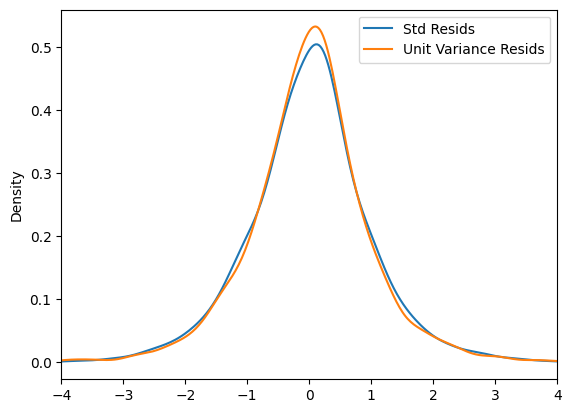

In [52]:
std_resid = res_normal.resid / res_normal.conditional_volatility
unit_var_resid = res_normal.resid / res_normal.resid.std()
df = pd.concat([std_resid, unit_var_resid], 1)
df.columns = ['Std Resids', 'Unit Variance Resids']
subplot = df.plot(kind='kde', xlim=(-4, 4))

In [53]:
res = arch_model(crude_ret, p=1, o=1, q=1, dist='skewt').fit(disp='off')
pd.DataFrame(res.params)

,params
mu,-0.007243
omega,0.038887
alpha[1],0.068447
gamma[1],-0.007317
beta[1],0.889398
eta,4.598800
lambda,-0.029206


In [54]:
sim_mod = arch_model(None, p=1, o=1, q=1, dist="skewt")

sim_data = sim_mod.simulate(res.params, 1000)
sim_data.head()

,data,volatility,errors
0,-0.699503,0.718884,-0.692260
1,0.617409,0.726510,0.624652
2,-1.916041,0.731460,-1.908798
3,-1.734015,0.858762,-1.726772
4,0.104774,0.936518,0.112018


<Axes: xlabel='Date'>

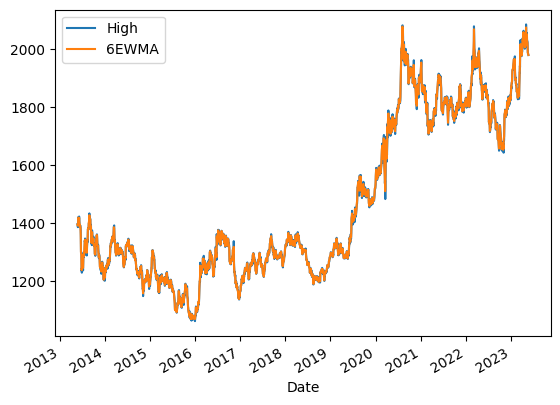

In [55]:
df = Gold
df['6EWMA'] = df['High'].ewm(span=2).mean()
df[['High','6EWMA']].plot()

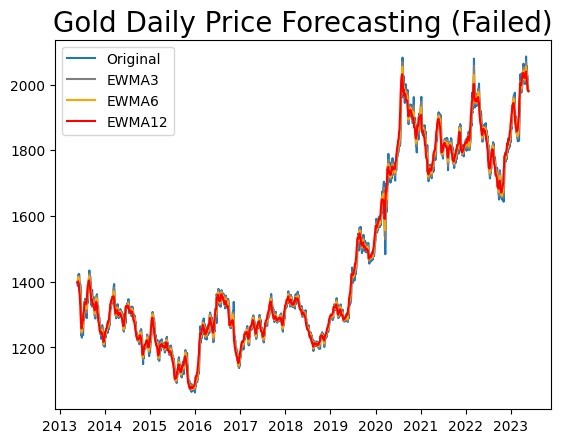

In [56]:
# Calculate
df['EWMA3'] = df['High'].ewm(span=3, adjust=False).mean()
df['EWMA6'] = df['High'].ewm(span=6, adjust=False).mean()
df['EWMA12'] = df['High'].ewm(span=12, adjust=False).mean()

# Plot
plt.title('Gold Daily Price Forecasting (Failed)', size=20)
plt.plot(df['High'], label='Original')
plt.plot(df['EWMA3'], color='gray', label='EWMA3')
plt.plot(df['EWMA6'], color='orange', label='EWMA6')
plt.plot(df['EWMA12'], color='red', label='EWMA12')
plt.legend();

In [57]:
%matplotlib inline
df_train = Gold['High']['2000':'2022']
df_test = Gold['High']['2022':]

# fit in statsmodels
model = ETSModel(
    df_train,
    error="add",
    trend="add",
    seasonal="add",
    damped_trend=True,
    seasonal_periods=20,
)
fit = model.fit()
print(fit.summary())

                                 ETS Results                                  
Dep. Variable:                   High   No. Observations:                 2443
Model:                      ETS(AAdA)   Log Likelihood               -9828.202
Date:                Wed, 24 May 2023   AIC                          19710.405
Time:                        14:53:27   BIC                          19867.031
Sample:                             0   HQIC                         19767.334
                               - 2443   Scale                          182.753
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.9999      0.021     47.293      0.000       0.958       1.041
smoothing_trend      9.999e-05      0.010      0.010      0.992      -0.019       0.019
smoothing_season

In [67]:
fit.get_prediction?

Signature:
fit.get_prediction(
    start=None,
    end=None,
    dynamic=False,
    index=None,
    method=None,
    simulate_repetitions=1000,
    **simulate_kwargs,
)
Docstring:
Calculates mean prediction and prediction intervals.

Parameters
----------
start : int, str, or datetime, optional
    Zero-indexed observation number at which to start forecasting,
    i.e., the first forecast is start. Can also be a date string to
    parse or a datetime type. Default is the the zeroth observation.
end : int, str, or datetime, optional
    Zero-indexed observation number at which to end forecasting, i.e.,
    the last forecast is end. Can also be a date string to
    parse or a datetime type. However, if the dates index does not
    have a fixed frequency, end must be an integer index if you
    want out of sample prediction. Default is the last observation in
    the sample.
dynamic : bool, int, str, or datetime, optional
    Integer offset relative to `start` at which to begin dynamic
  

In [84]:
pred = fit.get_prediction(start='2022', end='2013')
df = pred.summary_frame(alpha=0.05)
df

,mean,pi_lower,pi_upper
Date,,,
2022-12-30,1825.930186,1799.434206,1852.426165
2022-12-29,1827.448798,1800.952818,1853.944778
2022-12-28,1823.630504,1797.134525,1850.126484
2022-12-27,1820.133307,1793.637327,1846.629286
2022-12-23,1838.657410,1812.161430,1865.153390
...,...,...,...
2014-01-06,1243.008057,1216.512077,1269.504036
2014-01-03,1247.184014,1220.688035,1273.679994
2014-01-02,1239.984351,1213.488371,1266.480331


In [85]:
simulated = fit.simulate(anchor="end", nsimulations=191, repetitions=100)
simulated

,simulation.0,simulation.1,simulation.2,simulation.3,simulation.4,simulation.5,simulation.6,simulation.7,simulation.8,simulation.9,...,simulation.90,simulation.91,simulation.92,simulation.93,simulation.94,simulation.95,simulation.96,simulation.97,simulation.98,simulation.99
2443,1379.339965,1369.579723,1388.934094,1396.455434,1390.179209,1410.361521,1385.903495,1381.810900,1389.942226,1419.745202,...,1395.090659,1380.081731,1392.040701,1385.856751,1386.699940,1388.815849,1388.841781,1379.608017,1413.760885,1409.549310
2444,1354.656071,1375.347825,1392.464257,1421.612403,1376.440449,1404.793219,1404.011060,1413.955330,1394.879689,1434.246918,...,1383.532776,1371.140470,1385.477437,1378.418012,1388.864464,1396.219096,1402.631172,1404.968920,1432.484830,1396.184235
2445,1340.791129,1365.214246,1380.999994,1417.091125,1373.033860,1407.759687,1418.261769,1388.900370,1400.434182,1435.880316,...,1334.102200,1377.506665,1390.626318,1379.800071,1394.055171,1393.426193,1393.105266,1401.033742,1435.019182,1406.472946
2446,1334.813968,1387.710301,1352.158651,1409.199337,1384.729053,1409.901116,1425.738061,1365.795862,1395.325267,1445.745291,...,1316.755253,1370.467930,1408.159897,1356.941597,1387.523572,1411.589091,1394.590328,1393.466661,1433.061281,1404.065998
2447,1335.951658,1392.779065,1361.069850,1405.643474,1399.415162,1402.981516,1432.263524,1367.278712,1407.256445,1433.146306,...,1337.633587,1366.326016,1408.259850,1379.558765,1399.791600,1418.149254,1410.134360,1356.504063,1411.437657,1398.701771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2629,1113.952682,1507.721281,1477.755893,1280.190553,1783.473488,1391.899208,1625.734701,1582.218151,1208.733384,1632.139531,...,1217.236151,1520.664139,1425.993437,966.418280,1534.772587,1452.759529,1226.684011,1412.437715,1556.064963,1287.411185
2630,1108.376066,1509.106976,1477.911575,1296.410988,1798.638278,1395.674139,1635.934975,1601.900081,1209.459408,1627.695259,...,1246.139357,1512.862802,1445.274197,957.044802,1540.202824,1430.878203,1232.874734,1412.402505,1536.252835,1298.624724
2631,1095.962769,1503.826429,1466.268421,1297.494221,1783.234145,1380.797731,1648.241751,1627.606679,1209.670189,1619.195843,...,1264.108637,1508.073574,1445.017374,972.018756,1523.587926,1407.817756,1214.075005,1394.228353,1531.421389,1289.372973
2632,1105.927399,1541.385921,1481.182328,1291.250023,1781.646587,1384.578748,1631.823564,1613.643230,1254.342832,1612.743152,...,1278.145525,1495.219156,1466.153387,969.544722,1519.333255,1389.780911,1212.848368,1407.137074,1503.601970,1287.686800


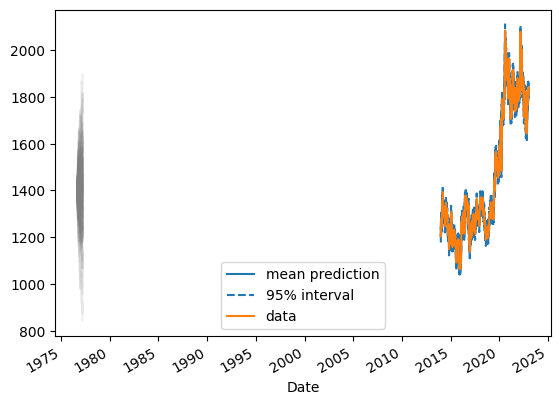

In [86]:
for i in range(simulated.shape[1]):
    simulated.iloc[:, i].plot(label="_", color="gray", alpha=0.1)
df["mean"].plot(label="mean prediction")
df["pi_lower"].plot(linestyle="--", color="tab:blue", label="95% interval")
df["pi_upper"].plot(linestyle="--", color="tab:blue", label="_")
pred.endog.plot(label="data")
plt.legend()